Análisis y preprocesamiento
En este caso se va a trabajar con un set de datos que contiene las donaciones de una organización
sin fines de lucro con la lista de correo de los donantes de sus campañas anteriores.
Se dispone de un archivo .csv y de un archivo .txt con la descripción del conjunto de datos.
Resulta importante siempre coocer el contexto del negocio y las características del set de datos del
que se dispone.
Existen sitios (como http://www.kaggle.com) donde se dispone de conjuntos de datos para ocupar
y, en muchos casos, se encontrará en el mismo lugar una descripción que ayudará a entender qué
es lo que se está entregando.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Carga de datos
data_frame = pd.read_csv("DataONG.csv", low_memory=False)
data_frame.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,DONOR_AMOUNT,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,8901,GRI,0,IL,61081,,,3712,0,,...,0.0,0,L,4,E,X,X,X,39.0,C
1,9401,NWN,0,LA,70611,,,0,0,,...,0.0,1,L,3,E,X,X,X,38.0,C
2,9401,MSD,1,TN,37127-,,,3211,0,,...,0.0,0,L,1,F,X,X,X,34.0,B
3,8901,ENQ,0,MN,56475,,,2603,0,,...,0.0,1,L,4,D,X,X,X,57.0,D
4,9201,HCC,1,LA,70791,,,0,0,X,...,0.0,0,L,1,G,X,X,X,38.0,B


Se sugiere que revise el archivo TXT para conocer (aunque sea de manera superficial) por ahora la
información de la cual se dispone

nálisis general
1. Conocer la cantidad de obsevaciones y la cantidad de características
2. Averiguar si existen datos nulos
3. Conocer la cantidad de columnas categóricas y numéricas (recuerde que muchos algoritmos trabajan solo con columnas numéricas y, eventualmente, hay que transformarlas)

In [3]:
data_frame.shape

(47720, 481)

In [4]:
data_frame.isnull().any().any()

True

In [5]:
# Agrupación de las columnas por tipo de datos
tipos = data_frame.columns.to_series().groupby(data_frame.dtypes).groups
# Conociendo la lista de columnas categóricas
ctext = tipos[np.dtype('object')]
len(ctext) # cantidad de columnas con datos categóricos.

68

In [9]:
# Conociendo la lista de columnas numéricas
columnas = data_frame.columns
cnum = list(set(columnas) - set(ctext))
len(cnum)

413

# Tratamiento de los nulos
# En el análisis anterior quedó en evidencia la existencia de valores nulos, razón por la cual hay que
# tratarlos.

In [10]:
# Completando valores faltantes datos cuantititavos
for columna in cnum:
  mean = data_frame[columna].mean()
  data_frame[columna] = data_frame[columna].fillna(mean)

In [11]:
# Completando valores faltantes datos categóricos
for columna in ctext:
  mode = data_frame[columna].mode()[0]
  data_frame[columna] = data_frame[columna].fillna(mode)

In [12]:
# Se vuelve a comprobar los nulos
data_frame.isnull().any().any()

False

In [13]:
# Guardando el dataset preprocesado
# Save transform datasets
data_frame.to_csv("DataONG_procesado.csv", index=False)

In [14]:
# Calculando el porcentaje de donantes sobre toda la base de datos
porcent_donantes = (data_frame[data_frame.DONOR_AMOUNT > 0]['DONOR_AMOUNT'].count() * 1.0/ data_frame['DONOR_AMOUNT'].count()) * 100.0
print("El procentaje de donantes es {0:.2f}%".format(porcent_donantes))

El procentaje de donantes es 5.08%


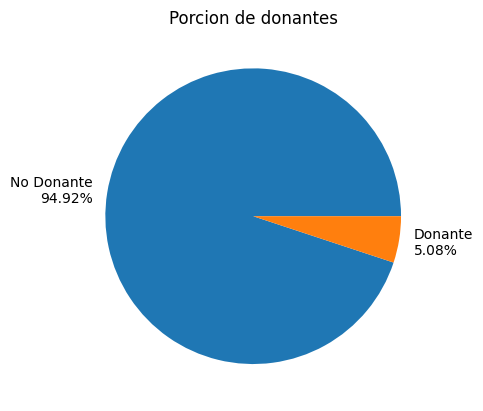

In [15]:
# Gráfico de tortas del porcentaje de donantes
# Agrupando por DONOR_FLAG
donantes = data_frame.groupby('DONOR_FLAG').IDX.count()
# Creando las leyendas del grafico.
labels = [ 'Donante\n' + str(round(x * 1.0 / donantes.sum() *100.0, 2)) + '%' for x in donantes ]
labels[0] = 'No ' + labels[0]
plt.pie(donantes, labels=labels)
plt.title('Porcion de donantes')
plt.show()

Análisis del gráfico
Se ve que el porcentaje de personas que fueron donantes en el pasado es realmente muy bajo, solo
un 5.08% del total de personas (2423).
Este es un dato importante a tener en cuenta si se pretende, por ejemplo, clasificar; ya que al existir
tanta diferencia entre las clases a clasificar, esto puede afectar considerablemente al algoritmo de
aprendizaje.
Conviene ahora explorar con más detalle a este grupo pequeño de personas que fueron donantes;
veamos por ejemplo como se dividen de acuerdo a la cantidad de dinero donado.

## Trabajando con filtro

In [16]:
#Creando subset con solo los donates
data_donantes = data_frame[data_frame.DONOR_AMOUNT > 0]
data_donantes.shape

(2423, 481)

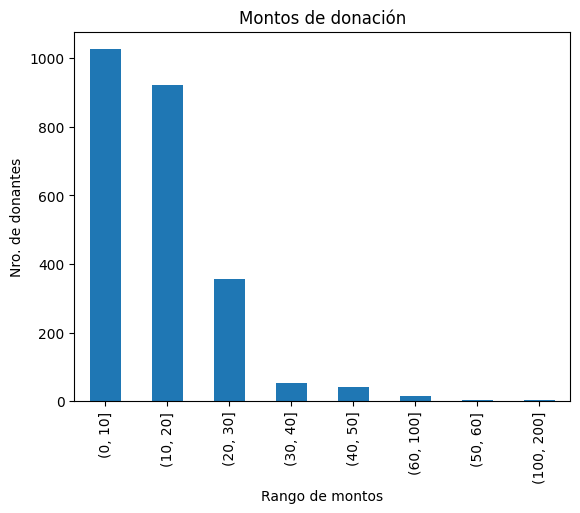

In [17]:
# Analizando el importe de donanciones
# Creando un segmentos de montos
monto_segm = pd.cut(data_donantes['DONOR_AMOUNT'], [0, 10, 20, 30, 40, 50, 60,100, 200])
# Creando el grafico de barras desde pandas
plot = pd.value_counts(monto_segm).plot(kind='bar', title='Montos de donación')
plot.set_ylabel('Nro. de donantes')
plot.set_xlabel('Rango de montos')
plt.show()

# Comentarios del gráfico
# Es posible apreciar que la mayor cantidad de montos de donaciones se encuentra entre el rango 0 y 30

In [18]:
# Agrupación por segmento según monto donado.
pd.value_counts(monto_segm)

(0, 10]       1026
(10, 20]       921
(20, 30]       358
(30, 40]        53
(40, 50]        43
(60, 100]       15
(50, 60]         4
(100, 200]       3
Name: DONOR_AMOUNT, dtype: int64

# Responder a algunas preguntas
# ¿Cuál es el promedio de donaciones?

In [19]:
# Monto de donación promedio
data_donantes['DONOR_AMOUNT'].mean()

15.598237721832438

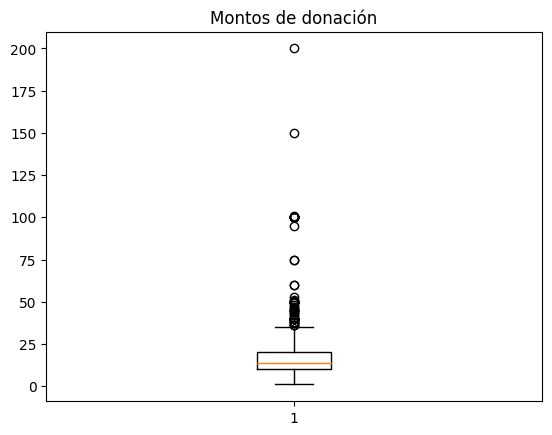

In [20]:
# Gráfico de cajas del importe de donación
plt.boxplot(list(data_donantes['DONOR_AMOUNT']))
plt.title('Montos de donación')
plt.show()

Este análisis muestra que la mayor cantidad de donaciones caen en un rango de importes entre 0 y
30 (tal y como se había eomentado antes), siendo la donación promedio 15.60. También es posible
ver que donaciones que superen un importe de 50 son casos realmente poco frecuentes, por lo que
constituyen valores atípicos y sería prudente eliminar estos casos al entrenar el modelo para que no
distorsionen los resultados.
Otra exploración interesante que se podría realizar sobre el set de datos relacionado con los donantes,
es ver cómo se divide este grupo en términos de género y edad.

## ¿Cuál es la distribución de los donantes por género?

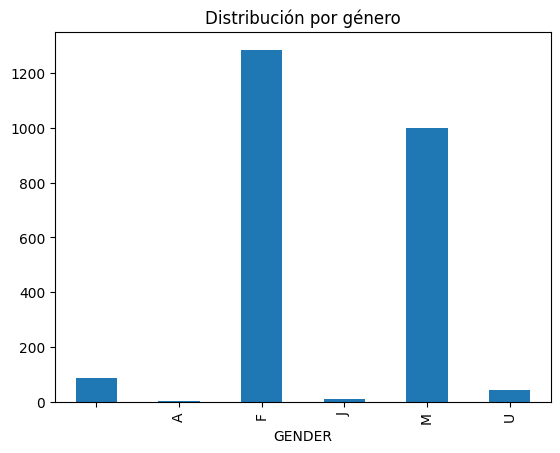

In [21]:
# Gráfico del género de los donantes
data_donantes.groupby('GENDER').size().plot(kind='bar')
plt.title('Distribución por género')
plt.show()

## ¿Cuál es la distribución de las donaciones según el género?

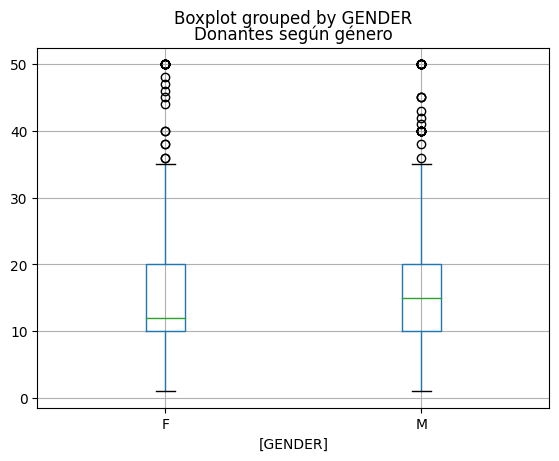

In [22]:
# Donaciones segùn el género
data_donantes[(data_donantes.DONOR_AMOUNT <= 50) & (data_donantes.GENDER.isin(['F', 'M'])
)][['DONOR_AMOUNT', 'GENDER']].boxplot(by='GENDER')
plt.title('Donantes según género')
plt.show()

In [23]:
# Media de monto donado por mujeres
data_donantes[data_donantes.GENDER == 'F'][['DONOR_AMOUNT']].mean()

DONOR_AMOUNT    14.610311
dtype: float64

In [24]:
# Media de monto donado por hombres
data_donantes[data_donantes.GENDER == 'M'][['DONOR_AMOUNT']].mean()

DONOR_AMOUNT    16.81989
dtype: float64

# Análisis de resultados
# Las mujeres suelen estar más propensas a donar, aunque donan un monto promedio menor (14.61)
# al que donan los hombres (16.82).
# Ahora se revisará el comportamiento de las donaciones respecto a la edad.

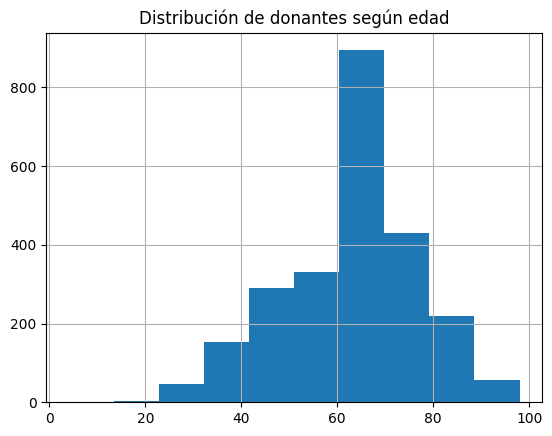

In [25]:
# Distribución de la edad de los donantes
data_donantes['AGE'].hist().set_title('Distribución de donantes según edad')
plt.show()

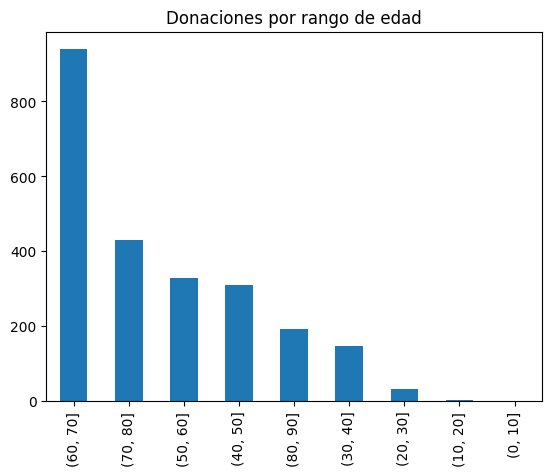

In [26]:
#Para mejorar la visualización se genera el gráfico considerando rango de edades
rango_edades = pd.cut(data_donantes['AGE'], range(0, 100, 10))
# Gráfico de barras de donaciones por edad
pd.value_counts(rango_edades).plot(kind='bar', title='Donaciones por rango de edad')
plt.show()

Análisis resultados
En este último análisis es posible apreciar que la mayor cantidad de los donantes son individuos
cuya edad se encuentra entre los 60 y 70 años, aunque la media de monto donado más alta la tienen
las personas que van desde los 30 a los 60 años.

# Trabajo futuro …
En las próximas experiencias es posible continuar con el ejemplo completando los restantes pasos
que incluye un proyecto de Minería de datos hasta llegar al modelo y poder utilizarlo para,
por ejemplo, realizar predicciones (selección de atributos - armado de modelo - entrenamiento -
evaluación - métricas - predicción)